# XPCS&XSVS Pipeline for Setup of (Gi)-SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Compress Data
* Define Q-ROI, e.g. qr for SAXS, (qr, qz) for gi-saxs

The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Load Packages

Import packages for I/O, visualization, and analysis.

In [1]:
from chxanalys.chx_packages import *

%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
import pickle as cpk

from skimage.draw import line_aa, line, polygon, ellipse

/opt/conda_envs/analysis/lib/python3.5/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "
/opt/conda_envs/analysis/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Define Scattering Geometry Here

In [2]:
scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'gi_saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'gi_waxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
                           # gi_waxs define a simple box-shaped ROI 
    
force_compress = False   
 

# Define Result Save Folder

In [3]:
CYCLE= '2016_2'  #change clycle here
username =  getpass.getuser()
path = '/XF11ID/analysis/%s/masks/'%CYCLE
data_dir0  = create_user_folder(CYCLE, username)
print( data_dir0 )

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/
/XF11ID/analysis/2016_2/yuzhang/Results/


## Load Metadata & Image Data

In [4]:
uid = 'e4fa1a'  #(scan num: 3086) (Measurement: PSPMMA2 180C 200 x10ms 1.0s period 4th )

uid = 'a0c868' #(scan num: 3085) (Measurement: PSPMMA2 180C 200 x10ms 1.0s period 3rd )'

In [5]:
data_dir = os.path.join(data_dir0, '%s/'%uid)
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
uidstr = 'uid=%s'%uid

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/a0c868/


In [6]:

sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

scan_id, full-uid, data path are:  3085--a0c8685e-b2fa-417d-a831-0baaf716067f--/XF11ID/data/2016/07/20/6b4222df-4f6b-4d51-a0e2_17


In [ ]:
md = get_meta_data( uid )
imgs = load_data( uid, md['detector'], reverse= False  )
md.update( imgs.md );Nimg = len(imgs);
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

md['acquire period' ] = md['cam_acquire_period']
md['exposure time'] =  md['cam_acquire_time']

In [9]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distance', 'beam_center_x', 'beam_center_y', ] )

suid--> a0c868
number of images--> 199
uid--> a0c8685e-b2fa-417d-a831-0baaf716067f
scan_id--> 3085
start_time--> 2016-07-20 13:39:08
stop_time--> 2016-07-20 13:42:30
sample--> PSPMMA2
Measurement--> PSPMMA2 180C 200 x10ms 1.0s period 3rd
acquire period--> 0.010009999386966228
exposure time--> 0.01
det_distance--> 4.84
beam_center_x--> 0.0
beam_center_y--> 0.0


In [33]:
imgs[0].shape

(2167, 2070)

In [55]:
center = [   1227,1261  ]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))
center = [   1227,1258  ]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))
center = [   1327,1358  ]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))


# Yugang modifiy here here
######################################
center = [   1327,1261  ]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))
center=[center[0], 2070 - center[1]]
######################################

inc_x0 =  center[1]
inc_y0=   center[0]

dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )

setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)

print_dict( setup_pargs )

The metadata: beam_center_x has been changed to 1327.
The metadata: beam_center_y has been changed to 809.
lambda_--> 1.5406
timeperframe--> 1.0
uid--> uid=a0c868
Ldet--> 4840.0
exposuretime--> 0.01
path--> /XF11ID/analysis/2016_2/yuzhang/Results/a0c868/
center--> [809, 1327]
dpix--> 0.0750000035623


# Load Mask file

In [35]:
mask_path = '/XF11ID/analysis/2016_2/masks/'
# mask_name = 'July18_mask.npy' #smaller than 160 C use this one
mask_name = 'July18_mask2.npy' #>= 160 C use this one

In [36]:
md['detector']

'image'

In [37]:
if md['detector'] =='eiger1m_single_image':
    Chip_Mask=np.load( '/XF11ID/analysis/2017_1/masks/Eiger1M_Chip_Mask.npy')
elif md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    Chip_Mask= np.array(np.load( '/XF11ID/analysis/2017_1/masks/Eiger4M_chip_mask.npy'), dtype=bool)
elif md['detector'] =='eiger500K_single_image':
    Chip_Mask= 1  #to be defined the chip mask
else:
    Chip_Mask = 1


In [38]:
#show_img(Chip_Mask)

<IPython.core.display.Javascript object>


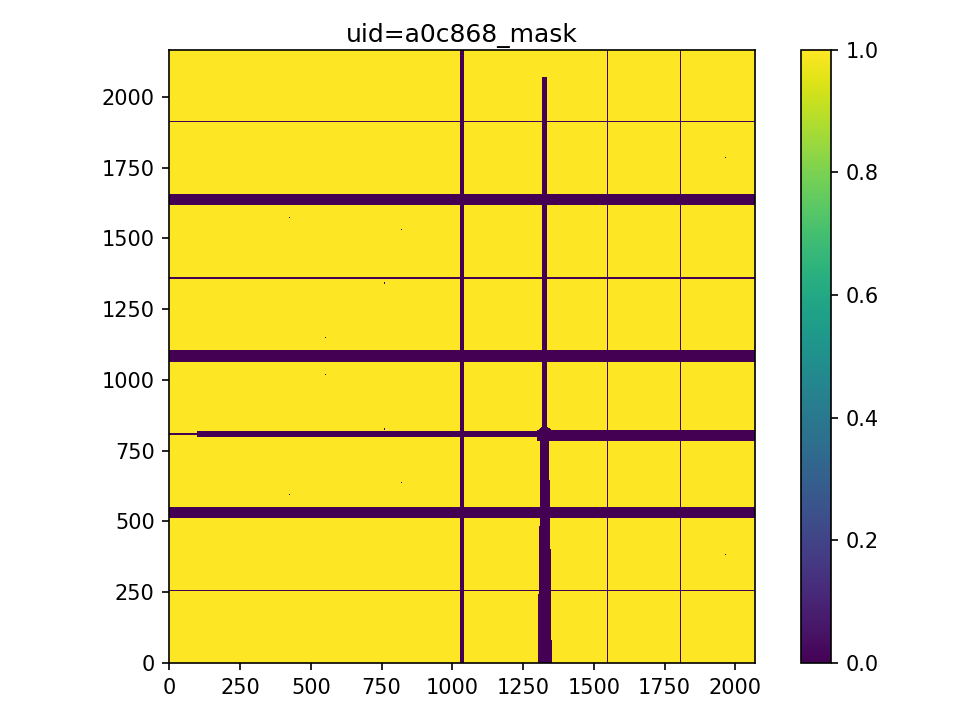

In [39]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = uidstr + '_mask', reverse= True ) 
mask =  mask * pixel_mask * Chip_Mask

show_img(mask,image_name = uidstr + '_mask', save=True, path=data_dir, aspect=1)
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

In [40]:
#show_img( imgs[0], vmin=.1e-4, vmax= 1e5, logs=True, aspect=1,cmap = cmap_albula)

In [31]:
#show_img( imgs[0]*mask, vmin=.1e-4, vmax= 1e5, logs=True, aspect=1,cmap = cmap_albula)

# Compress Data

In [18]:
good_start =5 # 5  #5  #make the good_start at least 0 

In [19]:
bin_frame = False #True # False # True  #generally make bin_frame as False
if bin_frame:
    bin_frame_number= 4
    timeperframe = acquisition_period * bin_frame_number
else:
    bin_frame_number =1

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_a0c8685e-b2fa-417d-a831-0baaf716067f.cmp.
The good_start frame number is: 5 
uid=a0c868_fra_5_199


<IPython.core.display.Javascript object>


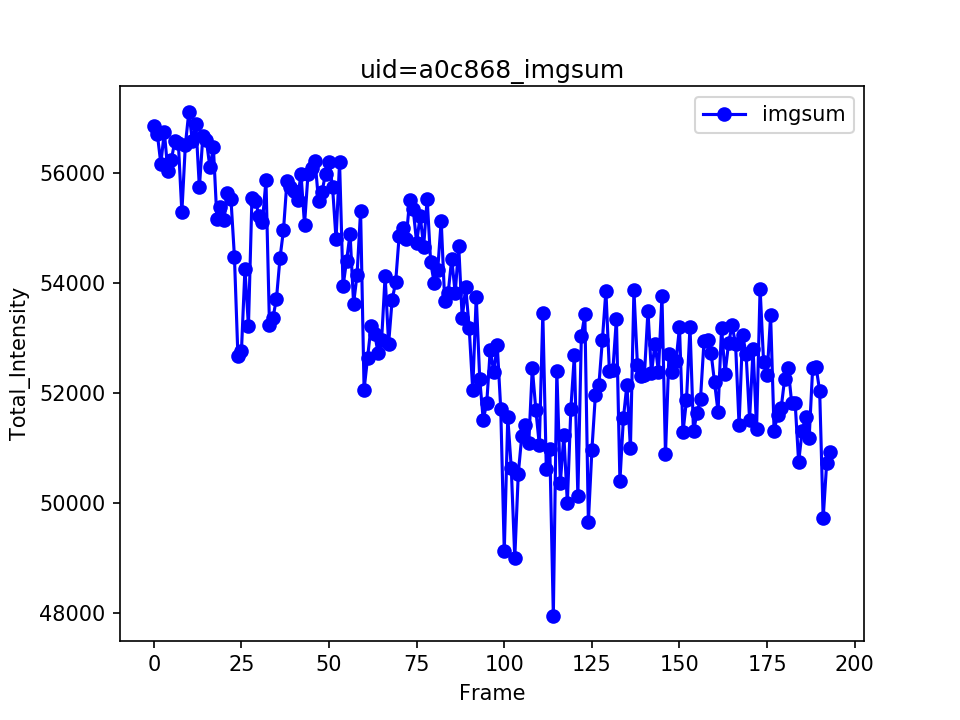

Total time: 0.291 sec


In [20]:
import time
t0= time.time()
if bin_frame_number==1:
    filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%md['uid']
else:
    filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s_bined--%s.cmp'%(md['uid'],bin_frame_number) 
mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
         force_compress= force_compress,  para_compress= True,  bad_pixel_threshold = 1e14,
                        bins=bin_frame_number, num_sub= 100, num_max_para_process= 500, with_pickle=True  )
min_inten = 10    
good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
print ('The good_start frame number is: %s '%good_start)

FD = Multifile(filename, good_start, len(imgs)//bin_frame_number)
#FD = Multifile(filename, good_start, 100)
uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
print( uid_ )
plot1D( y = imgsum[ np.array( [i for i in np.arange(good_start, len(imgsum)) if i not in bad_frame_list])],
       title =uidstr + '_imgsum', xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
Nimg = Nimg/bin_frame_number

run_time(t0)

# Show the average image with beam center

<IPython.core.display.Javascript object>


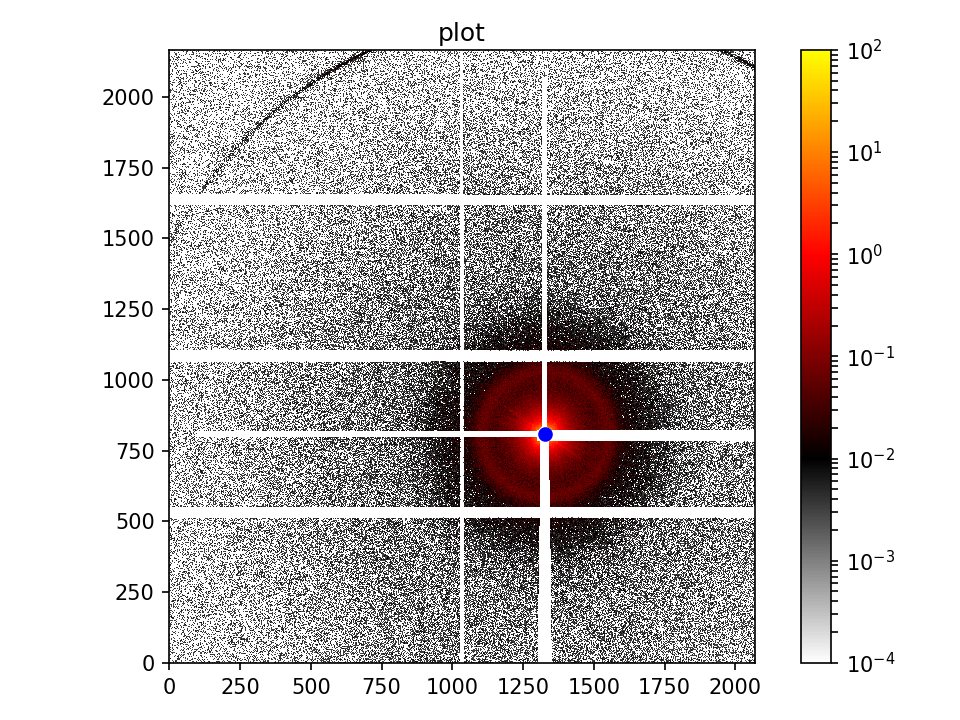

/opt/conda_envs/analysis/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [56]:
fig,ax = plt.subplots()
show_img( avg_img,  ax=[fig,ax], vmin=.0001, vmax= 1e2, logs=True, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg',  save=True, path=data_dir,  cmap = cmap_albula )
plot1D(center[0],center[1],ax=ax, c='b', m='o', legend='')

# Define ROI Depending on Scattering Geometry

## SAXS Scattering Geometry

In [57]:
center

[809, 1327]

In [58]:
setup_pargs 

{'Ldet': 4840.0,
 'center': [809, 1327],
 'dpix': 0.075000003562308848,
 'exposuretime': 0.0099999998,
 'lambda_': 1.5406013,
 'path': '/XF11ID/analysis/2016_2/yuzhang/Results/a0c868/',
 'timeperframe': 1.0,
 'uid': 'uid=a0c868'}

<IPython.core.display.Javascript object>


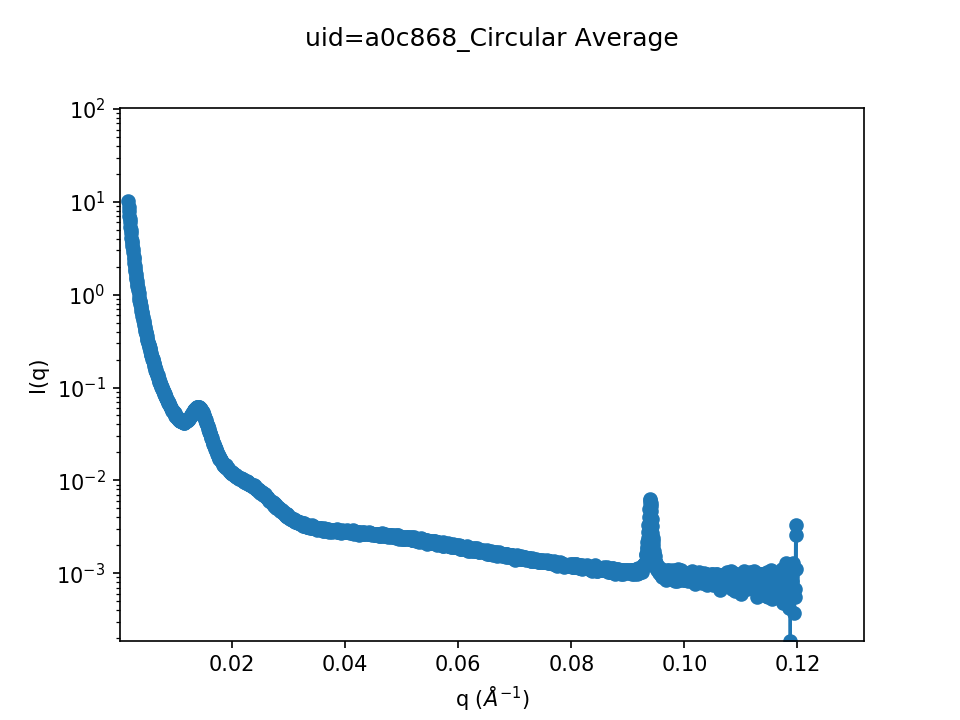

In [60]:
if scat_geometry =='saxs':
    ## Get circular average| * Do plot and save q~iq
    hmask = create_hot_pixel_mask( avg_img, threshold = 1e4, center=center, center_radius= 100)
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, 
                      xlim=[q_saxs.min() * 0.1, q_saxs.max()*1.1], ylim = [iq_saxs.min(), iq_saxs.max()*10] )
    mask =np.array( mask * hmask, dtype=bool) 

In [61]:
if scat_geometry =='saxs':    
    uniformq =  True # False    
    ## Define ROI
    #* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
    #* Create ring mask defined by  edges (all in pixel unit)    
    ### Define a non-uniform distributed rings by giving edges
    if not uniformq:    
        width = 0.0001  # in A-1    
        #width = 0.0001
        number_rings= 1 
        qcenters = [ 0.00146, 0.00156, 0.0017,   0.002,  0.0023,
                    0.0028,   0.0034, 0.00365, 0.00395, 
                    0.0048, 0.0050, 0.0052 ]#0.00639,0.00754, 0.00880  ] #in A-1 
            
            
        edges = get_non_uniform_edges(  qcenters, width, number_rings )    
        inner_radius= None
        outer_radius = None
        width = None
        num_rings = None        
    # Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)
    if uniformq:    
        inner_radius= 0.006
        outer_radius = 0.02
        num_rings = 8  #72
        gap_ring_number = 10
        width =    ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
        print(width)
        edges = None

0.0007777777777777778


8


<IPython.core.display.Javascript object>


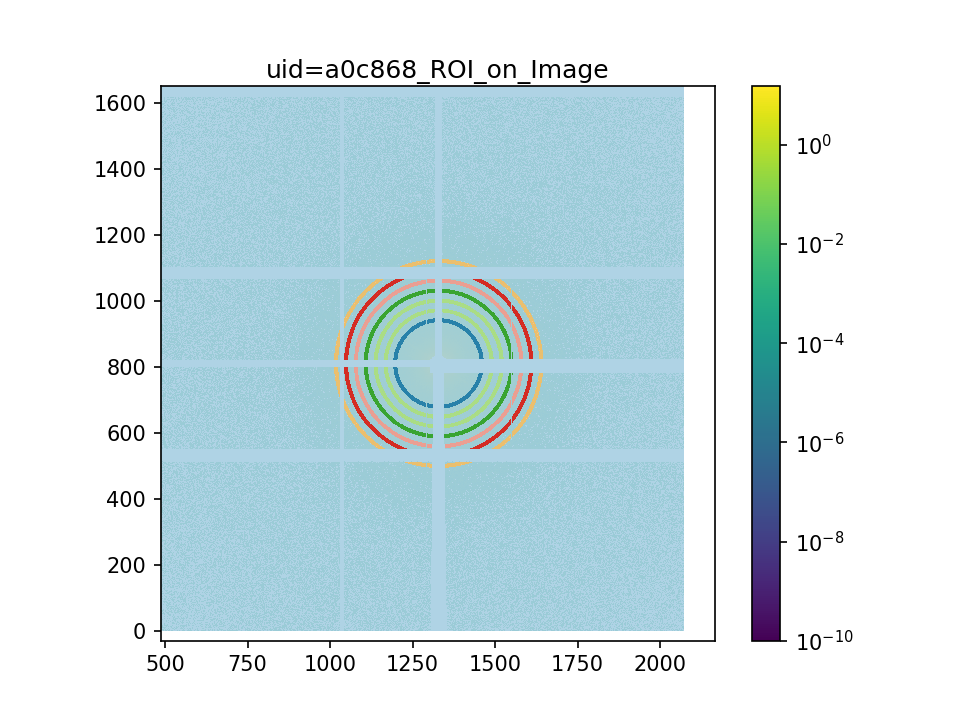

In [62]:
if scat_geometry =='saxs':
    roi_mask, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
            outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                          unit='A',       pargs=setup_pargs   )
    qind, pixelist = roi.extract_label_indices(  roi_mask  ) 
    qr = np.round( qr, 5)
    print(len(qr))
    show_ROI_on_image( avg_img, roi_mask, center, label_on = False, rwidth =840, alpha=.9,  
                     save=True, path=data_dir, uid=uidstr, vmin= np.min(avg_img), vmax= np.max(avg_img),
                     aspect=1) 
    qval_dict = get_qval_dict( np.round(qr, 5)  ) 

<IPython.core.display.Javascript object>


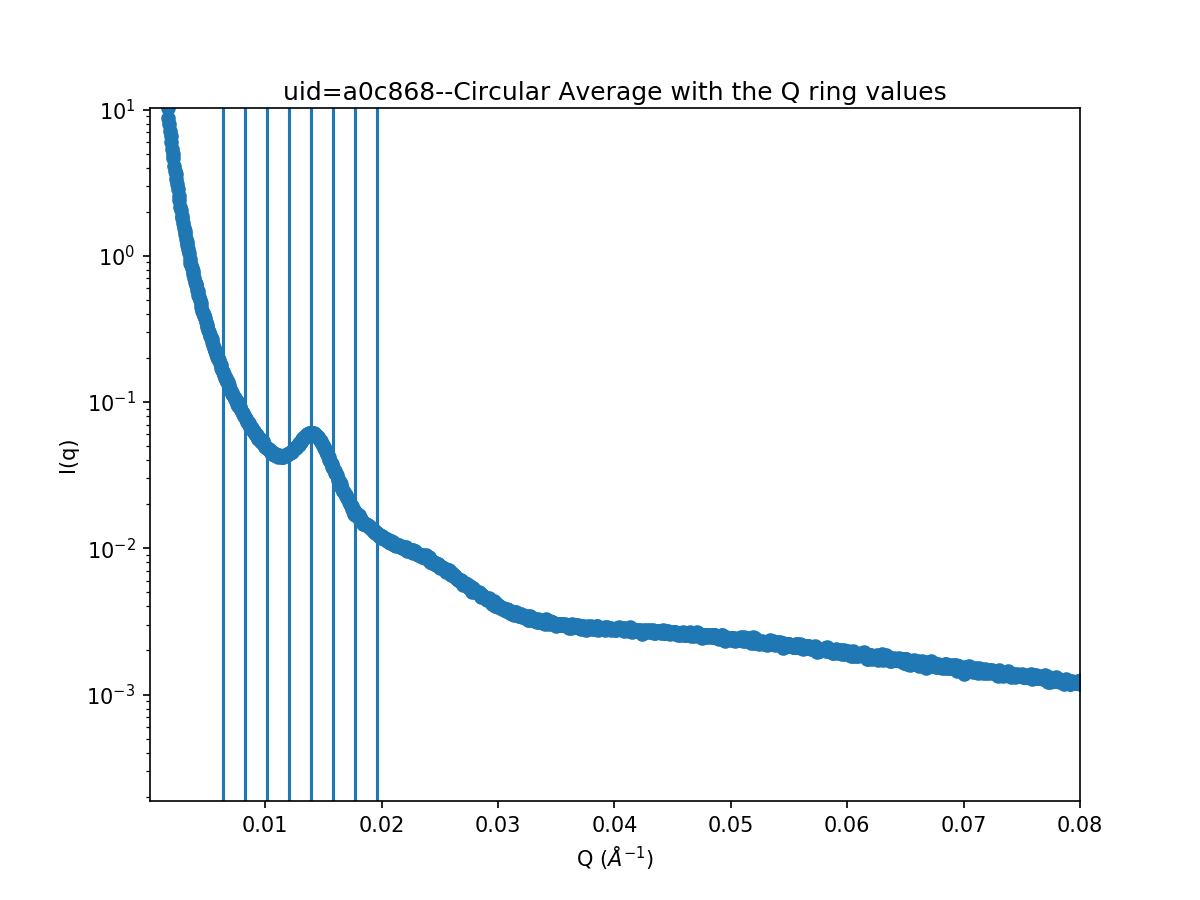

In [63]:
if scat_geometry =='saxs':
    plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uidstr, xlim=[0.0001,0.08],
                  ylim = [iq_saxs.min(), iq_saxs.max()],  save=True, path=data_dir)

# WAXS Geometry

In [121]:
def create_ellipse_donut(  cx, cy , wx_inner, wy_inner, wx_outer, wy_outer, roi_mask, gap=0):
    Nmax = np.max( np.unique( roi_mask ) )
    rr1, cc1 = ellipse( cy,cx,  wy_inner, wx_inner  )    
    rr2, cc2 = ellipse( cy, cx,  wy_inner + gap, wx_inner +gap ) 
    rr3, cc3 = ellipse( cy, cx,  wy_outer,wx_outer ) 
    roi_mask[rr3,cc3] = 2 + Nmax
    roi_mask[rr2,cc2] = 0
    roi_mask[rr1,cc1] = 1 + Nmax
    return roi_mask
    
def create_box( cx, cy, wx, wy, roi_mask):
    Nmax = np.max( np.unique( roi_mask ) )
    for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
        x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
        y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
        rr, cc = polygon( y,x)         
        roi_mask[rr,cc] = i +1 + Nmax
    return roi_mask


In [122]:
if scat_geometry =='gi_waxs':
    box_roi = True
    single_box = False   #True, if True, the roi is one box, else, roi is multi-boxes
    ellipse_roi = True
    
    if box_roi:
        if not single_box:
            roi_mask = np.zeros_like( avg_img , dtype = np.int32)
            wx,wy = [20,10]  #each box width and height

            cx = np.int_(np.linspace( 55, 955, 10))  #box center-x        
            nx = len(cx)//2

            y1 = 760-8
            y2=  780-8
            cy1 = np.linspace( y1, y2, nx)
            cy2 = np.linspace( y2, y1, nx)


            cy = np.int_( np.concatenate( [cy1, cy2] ) )  #box-center y

            for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
                x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
                y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
                rr, cc = polygon( y,x)
                #print( i + 1  )
                roi_mask[rr,cc] = i +1
            roi_mask = roi_mask * mask  
            
        else:

            roi_mask = np.zeros_like( avg_img , dtype = np.int32)
            wx,wy = [40,20]  #each box width and height    
            cx, cy = [[ 184, 817, 200, 800], [ 637, 637,200, 200]]     
            cx, cy = [[ 160, 817, 200, 800], [ 650, 637,200, 200]]    
            for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
                x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
                y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
                rr, cc = polygon( y,x)
                #print( i + 1  )
                roi_mask[rr,cc] = i +1

            if False:
                Nmax = np.max( np.unique( roi_mask ) )
                print( Nmax)
                wx,wy = [30,10]  #each box width and height    
                cx, cy = [[ 44, 80], [ 725, 725]]     
                for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
                    x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
                    y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
                    rr, cc = polygon( y,x)
                    #print( i + 1  )
                    roi_mask[rr,cc] = i +1 + Nmax
        
        
    if ellipse_roi ==True:
        #define donut shapes here
        roi_mask = np.zeros_like( avg_img , dtype = np.int32)
        wx1,wy1 = [30,15]  #inner ellipse width and height    
        wx2,wy2 = [80,40]  #outer ellipse width and height 
        gap=5        #gap between two ellipse
        #cx, cy = [[ 184, 817, 200, 800], [ 637, 637,200, 200]] 
        cx, cy = [[ 140, 886, 93, 920], [ 700, 700, 75, 75]]
        
        for i, [x,y] in enumerate(list( zip( cx,cy  ))):  #create ellipse
            roi_mask =  create_ellipse_donut(  x, y , wx1, wy1, 
                                              wx2, wy2, roi_mask, gap=gap)
    #define one box here
    wx,wy = [40,15]  #each box width and height    
    cx, cy = [[ 510], [ 880]]  
    roi_mask = create_box( cx, cy, wx, wy, roi_mask)

        
    roi_mask = roi_mask * mask  
    qind, pixelist = roi.extract_label_indices(roi_mask)
    noqs = len(np.unique(qind))
    qval_dict = get_qval_dict(   1 + np.arange(noqs)   ) 

In [123]:
if scat_geometry =='gi_waxs':
    badpixel = np.where( avg_img[:600,:] >=300 )
    roi_mask[badpixel] = 0
    show_ROI_on_image( avg_img, roi_mask, label_on = True,  alpha=.1,
                 save=True, path=data_dir, uid=uidstr, vmin=0.01, vmax=100, cmap = cmap_albula)

# GiSAXS Scattering Geometry

In [124]:
if scat_geometry =='gi_saxs':
    # Get Q-Map (Qz and Qr)
    ### Users put incident-Beam and Reflection_Beam Centers here!!!
    # Change these lines
    #inc_x0 =  1573 - 3
    #inc_y0 =  331

    #refl_x0 =  1574 - 3
    #refl_y0 =  903
    
    inc_x0 =  1539
    inc_y0 =  2167- 1928

    refl_x0 =  1539
    refl_y0 =  2167 - 1211
    
    # Don't Change these lines below here
    alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
    qx_map, qy_map, qr_map, qz_map = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )
    ticks_  = get_qzr_map(  qr_map, qz_map, inc_x0, Nzline=10,  Nrline=10   )
    ticks = ticks_[:4]
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks_, data= avg_img, uid= uidstr, path = data_dir   )

## Static Analysis for gisaxs

In [125]:
if scat_geometry =='gi_saxs':
    # For diffuse near Yoneda wing
    
    qz_start = 0.040  # was 0.046
    qz_end = 0.046
    qz_num= 1
    qz_width = 0.006

    qr_start =  0.002
    qr_end = 0.14
    qr_num = 1
    qr_width = 0.14  


    Qrs = [qr_start , qr_end, qr_width, qr_num]
    Qzs=  [qz_start,   qz_end,  qz_width , qz_num ]

    # Don't Change these lines below here
    roi_masks, qval_dicts = get_gisaxs_roi( Qrs, Qzs, qr_map, qz_map, mask= mask )
    show_qzr_roi( avg_img, roi_masks, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )


## Dynamic Analysis for gi_saxs

In [126]:
if scat_geometry =='gi_saxs':
    # Define Q-ROI
    #* Users provide the interested Qz and Qr here for XPCS analysis, e.g., qr start/end/number/width et.al
    # Change these lines

    
    qz_start = 0.040 + 0.002
    qz_end = 0.046 + 0.002
    qz_num= 2
    qz_width = 0.0015

    
    
    qr_start =  0.003
    qr_end = 0.028
    qr_num = 10
    qr_width = 0.002



    Qr = [qr_start , qr_end, qr_width, qr_num]
    Qz=  [qz_start,   qz_end,  qz_width , qz_num ]
    # Don't Change these lines below here
    roi_mask, qval_dict = get_gisaxs_roi( Qr, Qz, qr_map, qz_map, mask= mask )


In [127]:
if scat_geometry =='gi_saxs':
    ### Change the below lines to if define another ROI, if define even more, just repeat this process
    define_second_roi = False  #if True to define another line; else: make it False
    if define_second_roi:    
        qval_dict1 = qval_dict.copy()
        roi_mask1 = roi_mask.copy()
        del qval_dict, roi_mask
    ## The Second ROI
    if define_second_roi:    
        qz_start2 = 0.044
        qz_end2 = 0.05
        qz_num2= 1
        gap_qz_num2 = 1
        qz_width2 = 0.005 #(qz_end2 - qz_start2)/(qz_num2 +gap_qz_num2)    
        
        qr_start2 =  -0.003
        qr_end2 = 0.003
        qr_num2 = 1
        gap_qr_num2 = 5
        qr_width2 = 0.006 #( qr_end2- qr_start2)/(qr_num2+gap_qr_num2)        
        
        Qr2 = [qr_start2 , qr_end2, qr_width2, qr_num2]
        Qz2=  [qz_start2,   qz_end2,  qz_width2 , qz_num2 ] 
        roi_mask2, qval_dict2 = get_gisaxs_roi( Qr2, Qz2, qr_map, qz_map, mask= mask )
        
        qval_dict = update_qval_dict(  qval_dict1, qval_dict2 )
        roi_mask = update_roi_mask(  roi_mask1, roi_mask2 )  
        
    show_qzr_roi( avg_img, roi_mask, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )        
    ## Get 1D Curve (Q||-intensity¶)
    qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map, inc_x0= None, setup_pargs=setup_pargs )
    plot_qr_1d_with_ROI( qr_1d_pds, qr_center=np.unique( np.array(list( qval_dict.values() ) )[:,0] ),
                    loglog=False, save=True, uid=uidstr, path = data_dir)

# Refine the roi_mask by masking bad pixels

<IPython.core.display.Javascript object>


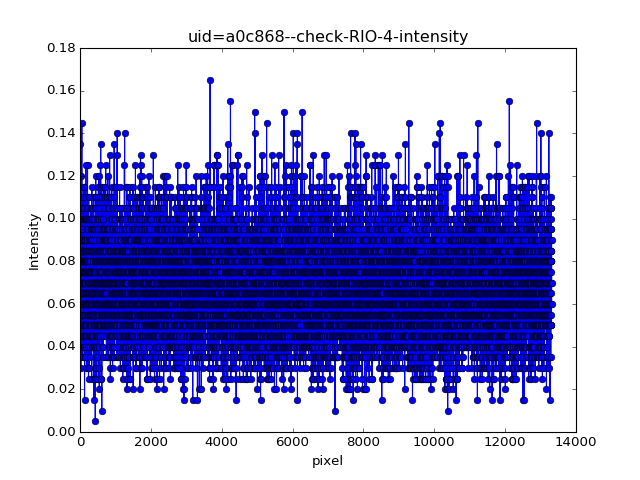

In [129]:
qint = 4
roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= qint, uid =uidstr )

In [130]:
refine_roi = False

In [131]:
Nq = len( np.unique(roi_mask))-1

In [132]:
if refine_roi:
#if scat_geometry =='saxs':
    filter_badpix_dict ={}
    for k in range(1, Nq +1 ):
        roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number=k, uid =uidstr, plot=False )    
        bad_pix_list=  get_bad_frame_list( roi_inten, fit=True, polyfit_order = 30, 
            scale= 3.5,  good_start = None, good_end= None, uid= uidstr, path=data_dir, plot=False)
        print( 'The bad frame list length is: %s'%len(bad_pix_list ) )
        filter_badpix_dict[k] = bad_pix_list

In [133]:
if refine_roi:
#if scat_geometry =='saxs':
    roi_mask = filter_roi_mask( filter_badpix_dict, roi_mask, avg_img, filter_type = 'badpix' )
    roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= qint, uid =uidstr )

In [134]:
path

'/XF11ID/analysis/2016_2/masks/'

In [136]:

fp = path + 'uid=%s_roi_mask.pkl'%uid
cpk.dump( [roi_mask,qval_dict],  open(fp, 'wb' ) )
print(fp)



##save with a meaningful filename
fp = path + 'anogales_roi_mask_June8.pkl'
cpk.dump( [roi_mask,qval_dict],  open(fp, 'wb' ) )
print(fp)



#roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data


/XF11ID/analysis/2016_2/masks/uid=a0c868_roi_mask.pkl
/XF11ID/analysis/2016_2/masks/anogales_roi_mask_June8.pkl


In [137]:
if scat_geometry == 'gi_saxs':
    
    
    fp = path + 'uid=%s_roi_masks.pkl'%uid
    cpk.dump( [roi_masks,qval_dicts],  open(fp, 'wb' ) )
    print(fp)

    fp = path + 'XX_roi_masks_June4.pkl'
    cpk.dump( [roi_masks,qval_dicts],  open(fp, 'wb' ) )
    print(fp)


    fp = path + 'XX_qmap_June4.pkl'    #dump qr_map, qz_map, ticks_, Qrs, Qzs, Qr, Qz, inc_x0
    print(fp)
    cpk.dump( [qr_map, qz_map, ticks_, Qrs, Qzs, Qr, Qz, inc_x0, refl_x0, refl_y0 ],  open(fp, 'wb' ) )

    